# Mixed-precision quantization of SpeechBrain Wav2Vec2 on GPU


This notebook provides code for mixed-precision quantization of the speechbrain/asr-wav2vec2-librispeech model. We compare base model and different mixed-precision quantized models on the librispeech dataset.

First, let's install `datasets`,  `transformers` and `librosa`.

In [1]:
# # %%capture
!pip install datasets==1.18.3
!pip install transformers==4.17.0
!pip install jiwer
!pip install librosa

In [2]:
device = 'cuda'

Next, we install `TensorRT` from source to use its tool `pytorch-quantization` for GPU quantization.

In [3]:
! git clone https://github.com/NVIDIA/TensorRT.git

In [4]:
! cd TensorRT/tools/pytorch-quantization && pip install .

In [5]:
! pip install --upgrade tensorrt

## Prepare Data

In [ ]:
from datasets import load_dataset, load_metric

# Dataset is downloaded from https://www.openslr.org/12
data = load_dataset("LibriSpeech")

In [7]:
from parse_data import parse_to_json
import json
import os

parse_to_json("./LibriSpeech/dev-clean")
os.rename('data.json', 'dev-clean.json')
with open('dev-clean.json', 'r') as file:
    dev_clean_data = json.load(file)

parse_to_json("./LibriSpeech/test-clean")
os.rename('data.json', 'test-clean.json')
with open('test-clean.json', 'r') as file:
    test_clean_data = json.load(file)

In [8]:
dev_clean_dict = {}
for key, value in dev_clean_data.items():
    new_key = key.replace('-', '')
    dev_clean_dict[new_key] = value

In [9]:
test_clean_dict = {}
for key, value in test_clean_data.items():
    new_key = key.replace('-', '')
    test_clean_dict[new_key] = value

In [10]:
import soundfile as sf
import resampy

def flac_to_array_with_sampling_rate(file_path, target_sr=16000):
    data, sr = sf.read(file_path, dtype='float32')

    if sr != target_sr:
        data = resampy.resample(data, sr, target_sr)

    return data

In [11]:
import re
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"]'

def remove_special_characters_dev(batch):
    batch["text"] = re.sub(chars_to_ignore_regex, '', batch["text"]).lower() + " "
    trimmed_string = batch["text"].strip()
    words = trimmed_string.split()
    new_text = ' '.join(words[1:])
    batch["text"] = new_text
    batch["input_values"] = flac_to_array_with_sampling_rate(dev_clean_dict[words[0]]['file_path'])
    return batch

In [ ]:
data['validation'] = data['validation'].map(remove_special_characters_dev)

In [13]:
import re
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"]'

def remove_special_characters_test(batch):
    batch["text"] = re.sub(chars_to_ignore_regex, '', batch["text"]).lower() + " "
    trimmed_string = batch["text"].strip()
    words = trimmed_string.split()
    new_text = ' '.join(words[1:])
    batch["text"] = new_text
    batch["input_values"] = flac_to_array_with_sampling_rate(test_clean_dict[words[0]]['file_path'])
    return batch

In [ ]:
data['test'] = data['test'].map(remove_special_characters_test)

## Base Model

In [15]:
from speechbrain.pretrained import EncoderASR
import torch

In [ ]:
asr_model = EncoderASR.from_hparams(source="speechbrain/asr-wav2vec2-librispeech", savedir="pretrained_models/asr-wav2vec2-librispeech", run_opts={"device":"cuda"})

In [22]:
torch.onnx.export(asr_model.mods.encoder.wav2vec2.model,
     args=torch.tensor(data['test'][:1]["input_values"]).cuda(),
     f="asr-wav2vec2-librispeech.onnx",
     export_params=True,
     opset_version=17,
     do_constant_folding=True,
     input_names = ['modelInput'],
     output_names = ['modelOutput'],
     dynamic_axes={'modelInput' : {0 : 'batch_size', 1: 'batch_size'},
     'modelOutput' : {0 : 'batch_size'}}
)

## Mixed-precision Quantization

In [23]:
import pytorch_quantization
from pytorch_quantization import nn as quant_nn
from pytorch_quantization import quant_modules
from pytorch_quantization.tensor_quant import QuantDescriptor
from pytorch_quantization import calib

In [ ]:
eight_bits_all_model_quantized = EncoderASR.from_hparams(source="speechbrain/asr-wav2vec2-librispeech", savedir="pretrained_models/asr-wav2vec2-librispeech", run_opts={"device":"cuda"})
four_bits_all_model_quantized = EncoderASR.from_hparams(source="speechbrain/asr-wav2vec2-librispeech", savedir="pretrained_models/asr-wav2vec2-librispeech", run_opts={"device":"cuda"})
four_bits_input_eight_bits_weight_model_quantized = EncoderASR.from_hparams(source="speechbrain/asr-wav2vec2-librispeech", savedir="pretrained_models/asr-wav2vec2-librispeech", run_opts={"device":"cuda"})
eight_bits_input_four_bits_weight_model_quantized = EncoderASR.from_hparams(source="speechbrain/asr-wav2vec2-librispeech", savedir="pretrained_models/asr-wav2vec2-librispeech", run_opts={"device":"cuda"})

In [25]:
quant_desc_input = QuantDescriptor(calib_method='max', num_bits=8, fake_quant=True)
quant_desc_weight = QuantDescriptor(num_bits=8, axis=(0))
quant_nn.QuantConv1d.set_default_quant_desc_input(quant_desc_input)
quant_nn.QuantConv1d.set_default_quant_desc_weight(quant_desc_weight)
quant_nn.QuantLinear.set_default_quant_desc_input(quant_desc_input)
quant_nn.QuantLinear.set_default_quant_desc_weight(quant_desc_weight)

In [ ]:
quant_modules.initialize()
eight_bits_all_model_full_quantized = EncoderASR.from_hparams(source="speechbrain/asr-wav2vec2-librispeech", savedir="pretrained_models/asr-wav2vec2-librispeech", run_opts={"device":"cuda"})

In [27]:
quant_desc_input = QuantDescriptor(calib_method='max', num_bits=4, fake_quant=True)
quant_desc_weight = QuantDescriptor(num_bits=4, axis=(0))
quant_nn.QuantConv1d.set_default_quant_desc_input(quant_desc_input)
quant_nn.QuantConv1d.set_default_quant_desc_weight(quant_desc_weight)
quant_nn.QuantLinear.set_default_quant_desc_input(quant_desc_input)
quant_nn.QuantLinear.set_default_quant_desc_weight(quant_desc_weight)

In [ ]:
quant_modules.initialize()
four_bits_all_model_full_quantized = EncoderASR.from_hparams(source="speechbrain/asr-wav2vec2-librispeech", savedir="pretrained_models/asr-wav2vec2-librispeech", run_opts={"device":"cuda"})

In [29]:
quant_desc_input = QuantDescriptor(calib_method='max', num_bits=4, fake_quant=True)
quant_desc_weight = QuantDescriptor(num_bits=8, axis=(0))
quant_nn.QuantConv1d.set_default_quant_desc_input(quant_desc_input)
quant_nn.QuantConv1d.set_default_quant_desc_weight(quant_desc_weight)
quant_nn.QuantLinear.set_default_quant_desc_input(quant_desc_input)
quant_nn.QuantLinear.set_default_quant_desc_weight(quant_desc_weight)

In [ ]:
quant_modules.initialize()
four_bits_input_eight_bits_weight_model_full_quantized = EncoderASR.from_hparams(source="speechbrain/asr-wav2vec2-librispeech", savedir="pretrained_models/asr-wav2vec2-librispeech", run_opts={"device":"cuda"})

In [31]:
quant_desc_input = QuantDescriptor(calib_method='max', num_bits=8, fake_quant=True)
quant_desc_weight = QuantDescriptor(num_bits=4, axis=(0))
quant_nn.QuantConv1d.set_default_quant_desc_input(quant_desc_input)
quant_nn.QuantConv1d.set_default_quant_desc_weight(quant_desc_weight)
quant_nn.QuantLinear.set_default_quant_desc_input(quant_desc_input)
quant_nn.QuantLinear.set_default_quant_desc_weight(quant_desc_weight)

In [ ]:
quant_modules.initialize()
eight_bits_input_four_bits_weight_model_full_quantized = EncoderASR.from_hparams(source="speechbrain/asr-wav2vec2-librispeech", savedir="pretrained_models/asr-wav2vec2-librispeech", run_opts={"device":"cuda"})

In [33]:
eight_bits_all_model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.enable_calib()
eight_bits_all_model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.disable_quant()

In [34]:
four_bits_all_model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.enable_calib()
four_bits_all_model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.disable_quant()

In [35]:
four_bits_input_eight_bits_weight_model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.enable_calib()
four_bits_input_eight_bits_weight_model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.disable_quant()

In [36]:
eight_bits_input_four_bits_weight_model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.enable_calib()
eight_bits_input_four_bits_weight_model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.disable_quant()

In [37]:
import torch
with torch.no_grad():
    for i in range(2000):
            _ = eight_bits_all_model_full_quantized.mods.encoder.wav2vec2.model(torch.tensor(data["validation"][i:i+1]["input_values"], device="cuda"))
            _ = four_bits_all_model_full_quantized.mods.encoder.wav2vec2.model(torch.tensor(data["validation"][i:i+1]["input_values"], device="cuda"))
            _ = four_bits_input_eight_bits_weight_model_full_quantized.mods.encoder.wav2vec2.model(torch.tensor(data["validation"][i:i+1]["input_values"], device="cuda"))
            _ = eight_bits_input_four_bits_weight_model_full_quantized.mods.encoder.wav2vec2.model(torch.tensor(data["validation"][i:i+1]["input_values"], device="cuda"))

In [38]:
# Finalize calibration

eight_bits_all_model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.load_calib_amax()
eight_bits_all_model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.disable_calib()
eight_bits_all_model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.enable_quant()

eight_bits_all_model_full_quantized.cuda()

W1230 12:01:57.217234 140719746998272 tensor_quantizer.py:238] Load calibrated amax, shape=torch.Size([512, 1, 1]).
W1230 12:01:57.218057 140719746998272 tensor_quantizer.py:239] Call .cuda() if running on GPU after loading calibrated amax.
W1230 12:01:57.218686 140719746998272 tensor_quantizer.py:174] Disable MaxCalibrator


EncoderASR(
  (mods): ModuleDict(
    (encoder): LengthsCapableSequential(
      (wav2vec2): HuggingFaceWav2Vec2(
        (model): Wav2Vec2Model(
          (feature_extractor): Wav2Vec2FeatureEncoder(
            (conv_layers): ModuleList(
              (0): Wav2Vec2LayerNormConvLayer(
                (conv): QuantConv1d(
                  1, 512, kernel_size=(10,), stride=(5,)
                  (_input_quantizer): TensorQuantizer(8bit fake per-tensor amax=dynamic calibrator=MaxCalibrator scale=1.0 quant)
                  (_weight_quantizer): TensorQuantizer(8bit fake axis=0 amax=[0.0071, 0.6079](512) calibrator=MaxCalibrator scale=1.0 quant)
                )
                (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
                (activation): GELUActivation()
              )
              (1-4): 4 x Wav2Vec2LayerNormConvLayer(
                (conv): QuantConv1d(
                  512, 512, kernel_size=(3,), stride=(2,)
                  (_input_quantizer

In [39]:
four_bits_all_model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.load_calib_amax()
four_bits_all_model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.disable_calib()
four_bits_all_model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.enable_quant()

four_bits_all_model_full_quantized.cuda()

W1230 12:01:57.231787 140719746998272 tensor_quantizer.py:238] Load calibrated amax, shape=torch.Size([512, 1, 1]).
W1230 12:01:57.232447 140719746998272 tensor_quantizer.py:174] Disable MaxCalibrator


EncoderASR(
  (mods): ModuleDict(
    (encoder): LengthsCapableSequential(
      (wav2vec2): HuggingFaceWav2Vec2(
        (model): Wav2Vec2Model(
          (feature_extractor): Wav2Vec2FeatureEncoder(
            (conv_layers): ModuleList(
              (0): Wav2Vec2LayerNormConvLayer(
                (conv): QuantConv1d(
                  1, 512, kernel_size=(10,), stride=(5,)
                  (_input_quantizer): TensorQuantizer(4bit fake per-tensor amax=dynamic calibrator=MaxCalibrator scale=1.0 quant)
                  (_weight_quantizer): TensorQuantizer(4bit fake axis=0 amax=[0.0071, 0.6079](512) calibrator=MaxCalibrator scale=1.0 quant)
                )
                (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
                (activation): GELUActivation()
              )
              (1-4): 4 x Wav2Vec2LayerNormConvLayer(
                (conv): QuantConv1d(
                  512, 512, kernel_size=(3,), stride=(2,)
                  (_input_quantizer

In [40]:
four_bits_input_eight_bits_weight_model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.load_calib_amax()
four_bits_input_eight_bits_weight_model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.disable_calib()
four_bits_input_eight_bits_weight_model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.enable_quant()

four_bits_input_eight_bits_weight_model_full_quantized.cuda()

W1230 12:01:57.245537 140719746998272 tensor_quantizer.py:238] Load calibrated amax, shape=torch.Size([512, 1, 1]).
W1230 12:01:57.246214 140719746998272 tensor_quantizer.py:174] Disable MaxCalibrator


EncoderASR(
  (mods): ModuleDict(
    (encoder): LengthsCapableSequential(
      (wav2vec2): HuggingFaceWav2Vec2(
        (model): Wav2Vec2Model(
          (feature_extractor): Wav2Vec2FeatureEncoder(
            (conv_layers): ModuleList(
              (0): Wav2Vec2LayerNormConvLayer(
                (conv): QuantConv1d(
                  1, 512, kernel_size=(10,), stride=(5,)
                  (_input_quantizer): TensorQuantizer(4bit fake per-tensor amax=dynamic calibrator=MaxCalibrator scale=1.0 quant)
                  (_weight_quantizer): TensorQuantizer(8bit fake axis=0 amax=[0.0071, 0.6079](512) calibrator=MaxCalibrator scale=1.0 quant)
                )
                (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
                (activation): GELUActivation()
              )
              (1-4): 4 x Wav2Vec2LayerNormConvLayer(
                (conv): QuantConv1d(
                  512, 512, kernel_size=(3,), stride=(2,)
                  (_input_quantizer

In [41]:
eight_bits_input_four_bits_weight_model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.load_calib_amax()
eight_bits_input_four_bits_weight_model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.disable_calib()
eight_bits_input_four_bits_weight_model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.enable_quant()

eight_bits_input_four_bits_weight_model_full_quantized.cuda()

W1230 12:01:57.258272 140719746998272 tensor_quantizer.py:238] Load calibrated amax, shape=torch.Size([512, 1, 1]).
W1230 12:01:57.258880 140719746998272 tensor_quantizer.py:174] Disable MaxCalibrator


EncoderASR(
  (mods): ModuleDict(
    (encoder): LengthsCapableSequential(
      (wav2vec2): HuggingFaceWav2Vec2(
        (model): Wav2Vec2Model(
          (feature_extractor): Wav2Vec2FeatureEncoder(
            (conv_layers): ModuleList(
              (0): Wav2Vec2LayerNormConvLayer(
                (conv): QuantConv1d(
                  1, 512, kernel_size=(10,), stride=(5,)
                  (_input_quantizer): TensorQuantizer(8bit fake per-tensor amax=dynamic calibrator=MaxCalibrator scale=1.0 quant)
                  (_weight_quantizer): TensorQuantizer(4bit fake axis=0 amax=[0.0071, 0.6079](512) calibrator=MaxCalibrator scale=1.0 quant)
                )
                (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
                (activation): GELUActivation()
              )
              (1-4): 4 x Wav2Vec2LayerNormConvLayer(
                (conv): QuantConv1d(
                  512, 512, kernel_size=(3,), stride=(2,)
                  (_input_quantizer

In [42]:
eight_bits_all_model_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv = eight_bits_all_model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv
four_bits_all_model_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv = four_bits_all_model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv
four_bits_input_eight_bits_weight_model_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv = four_bits_input_eight_bits_weight_model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv
eight_bits_input_four_bits_weight_model_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv = eight_bits_input_four_bits_weight_model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv


In [ ]:
torch.onnx.export(eight_bits_all_model_full_quantized.mods.encoder.wav2vec2.model,
             args=torch.tensor(data['test'][:1]["input_values"]).cuda(),
             f="asr-wav2vec2-librispeech-encoder-eight_bits_all_model_quantized.onnx",
             export_params=True,
             opset_version=17,
             do_constant_folding=True,
             input_names = ['modelInput'],
             output_names = ['modelOutput'],
             dynamic_axes={'modelInput' : {0 : 'batch_size', 1: 'batch_size'},
             'modelOutput' : {0 : 'batch_size'}}
)

In [44]:
torch.onnx.export(four_bits_all_model_full_quantized.mods.encoder.wav2vec2.model,
             args=torch.tensor(data['test'][:1]["input_values"]).cuda(),
             f="asr-wav2vec2-librispeech-encoder-four_bits_all_model_quantized.onnx",
             export_params=True,
             opset_version=17,
             do_constant_folding=True,
             input_names = ['modelInput'],
             output_names = ['modelOutput'],
             dynamic_axes={'modelInput' : {0 : 'batch_size', 1: 'batch_size'},
             'modelOutput' : {0 : 'batch_size'}}
)

In [45]:
torch.onnx.export(four_bits_input_eight_bits_weight_model_quantized.mods.encoder.wav2vec2.model,
             args=torch.tensor(data['test'][:1]["input_values"]).cuda(),
             f="asr-wav2vec2-librispeech-encoder-four_bits_input_eight_bits_weight_model_quantized.onnx",
             export_params=True,
             opset_version=17,
             do_constant_folding=True,
             input_names = ['modelInput'],
             output_names = ['modelOutput'],
             dynamic_axes={'modelInput' : {0 : 'batch_size', 1: 'batch_size'},
             'modelOutput' : {0 : 'batch_size'}}
)

In [47]:
torch.onnx.export(eight_bits_input_four_bits_weight_model_quantized.mods.encoder.wav2vec2.model,
             args=torch.tensor(data['test'][:1]["input_values"]).cuda(),
             f="asr-wav2vec2-librispeech-encoder-eight_bits_input_four_bits_weight_model_quantized.onnx",
             export_params=True,
             opset_version=17,
             do_constant_folding=True,
             input_names = ['modelInput'],
             output_names = ['modelOutput'],
             dynamic_axes={'modelInput' : {0 : 'batch_size', 1: 'batch_size'},
             'modelOutput' : {0 : 'batch_size'}}
)

### Base vs Quantized Models Inference Time

In this section, we compare the inference time of the base model and the quantized models on the test data. Furthermore, we evalute the perfomance of the base and the quantized models using the word error rate (WER) metric.

**Inference**

In [ ]:
# ! pip install onnxruntime-gpu

In [48]:
import onnxruntime as ort
import tensorrt
ort.get_device()

'GPU'

In [ ]:
# Load onnx models
ort_sess_eight_bits_all_model_quantized = ort.InferenceSession('asr-wav2vec2-librispeech-encoder-eight_bits_all_model_quantized.onnx', providers=['TensorrtExecutionProvider'])
ort_sess_four_bits_all_model_quantized = ort.InferenceSession('asr-wav2vec2-librispeech-encoder-four_bits_all_model_quantized.onnx', providers=['TensorrtExecutionProvider'])
ort_sess_four_bits_input_eight_bits_weight_model_quantized = ort.InferenceSession('asr-wav2vec2-librispeech-encoder-four_bits_input_eight_bits_weight_model_quantized.onnx', providers=['TensorrtExecutionProvider'])
ort_sess_eight_bits_input_four_bits_weight_model_quantized = ort.InferenceSession('asr-wav2vec2-librispeech-encoder-eight_bits_input_four_bits_weight_model_quantized.onnx', providers=['TensorrtExecutionProvider'])
ort_sess_base = ort.InferenceSession('asr-wav2vec2-librispeech.onnx')

In [50]:
import time
import numpy

def compute_inference_time(ort_sess, num_samples):
    model_time = 0
    with torch.no_grad():
        for single_batch in data["test"].select(range(num_samples)):
            input_values = torch.tensor(single_batch["input_values"], device="cpu").unsqueeze(0)
            input_values = input_values.clone().detach().numpy().astype(numpy.float32)
            starttime = time.time()
            ort_sess.run(['modelOutput'], {'modelInput': input_values})
            model_time += time.time() - starttime
    return round(model_time/num_samples, 8)

In [51]:
num_samples = 500

base_model_time = compute_inference_time(ort_sess_base, num_samples)

In [52]:
print(f'Base Model inference time {base_model_time} seconds')

Base Model inference time 0.46591045 seconds


In [61]:
ort_sess_eight_bits_all_model_quantized_time = compute_inference_time(ort_sess_eight_bits_all_model_quantized, num_samples)

In [62]:
print(f'Quantized Model, all layers with 8 bits, inference time {ort_sess_eight_bits_all_model_quantized_time} seconds')

Quantized Model, all layers with 8 bits, inference time 0.02071843 seconds


In [63]:
ort_sess_four_bits_all_model_quantized_time = compute_inference_time(ort_sess_four_bits_all_model_quantized, num_samples)

In [64]:
print(f'Quantized Model, all layers with 4 bits, inference time {ort_sess_four_bits_all_model_quantized_time} seconds')

Quantized Model, all layers with 4 bits, inference time 0.0206431 seconds


In [65]:
ort_sess_four_bits_input_eight_bits_weight_model_quantized_time = compute_inference_time(ort_sess_four_bits_input_eight_bits_weight_model_quantized, num_samples)

In [66]:
print(f'Quantized Model, 4 bits input and 8 bits weight, inference time {ort_sess_four_bits_input_eight_bits_weight_model_quantized_time} seconds')

Quantized Model, 4 bits input and 8 bits weight, inference time 0.02027395 seconds


In [67]:
ort_sess_eight_bits_input_four_bits_weight_model_quantized_time = compute_inference_time(ort_sess_eight_bits_input_four_bits_weight_model_quantized, num_samples)

In [68]:
print(f'Quantized Model, 8 bits input and 4 bits weight, inference time {ort_sess_eight_bits_input_four_bits_weight_model_quantized_time} seconds')

Quantized Model, 8 bits input and 4 bits weight, inference time 0.0202755 seconds


**Inference Time Visualisation of Results**

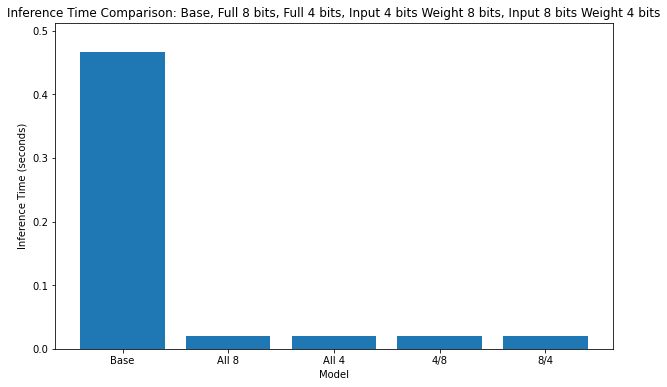

In [69]:
import matplotlib.pyplot as plt

models = ['Base', 'All 8', 'All 4', '4/8', '8/4']
inference_times = [base_model_time, ort_sess_eight_bits_all_model_quantized_time, ort_sess_four_bits_all_model_quantized_time, ort_sess_four_bits_input_eight_bits_weight_model_quantized_time, ort_sess_eight_bits_input_four_bits_weight_model_quantized_time]

plt.figure(figsize=(10, 6))
plt.bar(models, inference_times)
plt.xlabel('Model')
plt.ylabel('Inference Time (seconds)')
plt.title('Inference Time Comparison: Base, Full 8 bits, Full 4 bits, Input 4 bits Weight 8 bits, Input 8 bits Weight 4 bits')
plt.ylim(0, max(inference_times) * 1.1)
plt.show()

**Evaluating WER metric**

In [70]:
wer_metric = load_metric("wer")

In [71]:
def map_model_to_wer_result(model, single_batch):
    input_values = torch.tensor(single_batch["input_values"]).to('cuda')
    with torch.no_grad():
        prediction = model.transcribe_batch(input_values, torch.tensor([1.0]).to('cuda'))
    return wer_metric.compute(predictions=[prediction[0][0].lower()], references=single_batch['text'])

In [72]:
num_samples = len(data['test'])

In [ ]:
total_wer = 0

for i in range(num_samples):
    total_wer += map_model_to_wer_result(asr_model, data['test'][i:i+1])

base_wer_result = round(total_wer / num_samples, 8)

/home/kmb85/miniconda3/lib/python3.11/site-packages/speechbrain/dataio/encoder.py:722: UserWarning: CTCTextEncoder.expect_len was never called: assuming category count of 31 to be correct! Sanity check your encoder using `.expect_len`. Ensure that downstream code also uses the correct size. If you are sure this does not apply to you, use `.ignore_len`.
  warnings.warn(


In [ ]:
print(f'Base Model WER: {base_wer_result}')

Base Model WER: 0.0229245


In [ ]:
total_wer_eight_bits_all_model_quantized = 0

for i in range(num_samples):
    total_wer_eight_bits_all_model_quantized += map_model_to_wer_result(eight_bits_all_model_quantized, data['test'][i:i+1])

eight_bits_all_model_quantized_wer_result = round(total_wer_eight_bits_all_model_quantized / num_samples, 8)

In [ ]:
print(f'Quantized Model, all layers with 8 bits, WER: {eight_bits_all_model_quantized_wer_result}')

Quantized Model, all layers with 8 bits, WER: 0.02383462


In [ ]:
total_wer_four_bits_all_model_quantized = 0

for i in range(num_samples):
    total_wer_four_bits_all_model_quantized += map_model_to_wer_result(four_bits_all_model_quantized, data['test'][i:i+1])

total_wer_four_bits_all_model_quantized_wer_result = round(total_wer_four_bits_all_model_quantized / num_samples, 8)

In [ ]:
print(f'Quantized Model, all layers with 4 bits, WER: {total_wer_four_bits_all_model_quantized_wer_result}')

Quantized Model, all layers with 4 bits, WER: 0.45084591


In [ ]:
total_four_bits_input_eight_bits_weight_model_quantized = 0

for i in range(num_samples):
    total_four_bits_input_eight_bits_weight_model_quantized += map_model_to_wer_result(four_bits_input_eight_bits_weight_model_quantized, data['test'][i:i+1])

four_bits_input_eight_bits_weight_model_quantized_wer_result = round(total_four_bits_input_eight_bits_weight_model_quantized / num_samples, 8)

In [ ]:
print(f'Quantized Model, 4 bits input and 8 bits weight, WER: {four_bits_input_eight_bits_weight_model_quantized_wer_result}')

Quantized Model, 4 bits input and 8 bits weight, WER: 0.45674485


In [ ]:
total_eight_bits_input_four_bits_weight_model_quantized = 0

for i in range(num_samples):
    total_eight_bits_input_four_bits_weight_model_quantized += map_model_to_wer_result(eight_bits_input_four_bits_weight_model_quantized, data['test'][i:i+1])

eight_bits_input_four_bits_weight_model_quantized_wer_result = round(total_eight_bits_input_four_bits_weight_model_quantized / num_samples, 8)

In [ ]:
print(f'Quantized Model, 8 bits input and 4 bits weight, WER: {eight_bits_input_four_bits_weight_model_quantized_wer_result}')

Quantized Model, 8 bits input and 4 bits weight, WER: 0.02423052


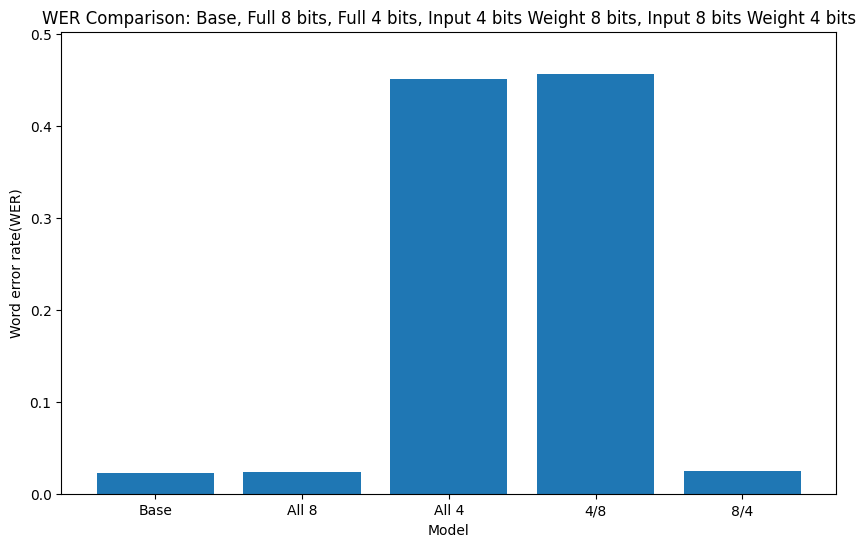

In [ ]:
import matplotlib.pyplot as plt

models = ['Base', 'All 8', 'All 4', '4/8', '8/4']
inference_times = [base_wer_result, eight_bits_all_model_quantized_wer_result, total_wer_four_bits_all_model_quantized_wer_result, four_bits_input_eight_bits_weight_model_quantized_wer_result, eight_bits_input_four_bits_weight_model_quantized_wer_result]

plt.figure(figsize=(10, 6))
plt.bar(models, inference_times)
plt.xlabel('Model')
plt.ylabel('Word error rate(WER)')
plt.title('WER Comparison: Base, Full 8 bits, Full 4 bits, Input 4 bits Weight 8 bits, Input 8 bits Weight 4 bits')
plt.ylim(0, max(inference_times) * 1.1)
plt.show()